In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
from scipy.spatial.distance import pdist
from snapfish2 import MulFish
from snapfish2.utils.covar import *
from scipy import stats

import matplotlib as mpl
# remove the top and right spines
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
# remove the border of legend
mpl.rcParams["legend.frameon"] = False
# mpl.rcParams["legend.loc"] = (1, 0.5)
cmap = plt.get_cmap("seismic_r")
cmap.set_bad("white")
pal = sns.color_palette("pastel")

In [2]:
%reload_ext autoreload
%autoreload 2

## 1 Simulation

In [3]:
def covar_func(x, s, r):
    return s * np.exp(-np.abs(x)/r)

def to_pairwise_df(s, r, n, pos):
    pos = pos[:,None]
    cov = covar_func(pos - pos.T, s=s, r=r)
    samples = stats.multivariate_normal.rvs(cov=cov, size=n)

    # observed probability
    obs_ratio = 0.5
    mask = stats.bernoulli.rvs(obs_ratio, size=samples.size)
    mask = mask.reshape(samples.shape) == 0
    samples[mask] = np.nan

    samples_df = pd.DataFrame({
        "Trace_ID":np.repeat(np.arange(n), len(pos)),
        "Chrom_Start":np.tile(pos.flatten(), n),
        "X":samples.flatten()
    })

    p1d_dist = np.concatenate(
        samples_df
        .dropna()
        .groupby("Trace_ID", sort=False)[["Chrom_Start"]]
        .apply(pdist)
        .values
    )
    pax_dist = np.square(np.concatenate(
        samples_df
        .dropna()
        .groupby("Trace_ID", sort=False)[["X"]]
        .apply(pdist)
        .values
    ))

    pairwise_df = pd.DataFrame({
        "1D":p1d_dist,
        "3D^2":pax_dist
    })
    pairwise_df["cov"] = covar_func(pairwise_df["1D"], s=s, r=r)
    pairwise_df["3D^2 from cov"] = 2*s - 2*pairwise_df["cov"]
    return pairwise_df

<Axes: xlabel='1D', ylabel='value'>

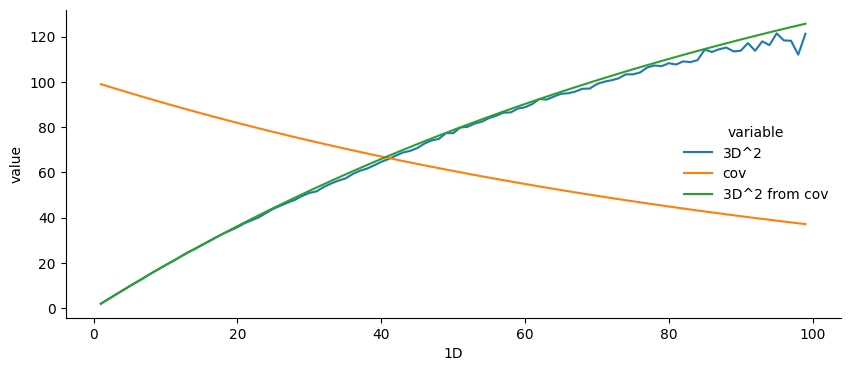

In [4]:
s, r, n = 100, 100, 1000
pos = np.arange(100)
pairwise_df = to_pairwise_df(s, r, n, pos)
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(pairwise_df.melt(id_vars="1D"), x="1D", y="value", hue="variable", errorbar=None)

<Axes: xlabel='1D', ylabel='value'>

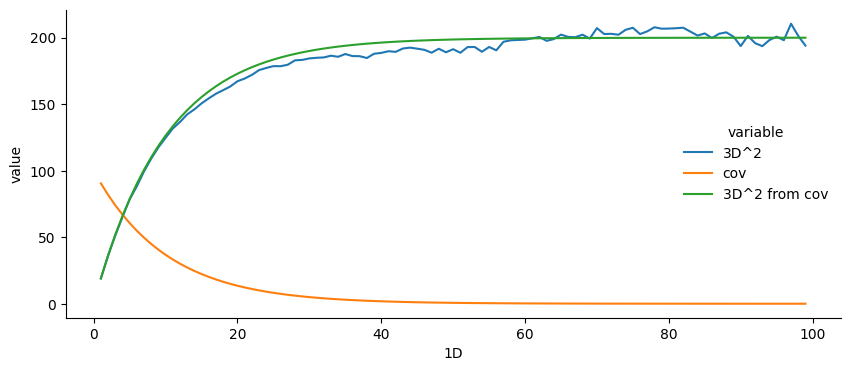

In [5]:
s, r, n = 100, 10, 1000
pos = np.arange(100)
pairwise_df = to_pairwise_df(s, r, n, pos)
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(pairwise_df.melt(id_vars="1D"), x="1D", y="value", hue="variable", errorbar=None)

## 2 Covariance function parameters for seqFISH+ 1Mb mouse brain

In [4]:
path = "data/jie_aligned_takei_nature_2021/4DNFIS6MLXGA.csv"
# path = "data/jie_aligned_takei_nature_2021/4DNFI7G3BWDF.csv"
data = MulFish(path)
# filter out traces with more than 50% missing
count_df = data.data.groupby("Trace_ID", sort=False).count()
missing_ratio = 1 - count_df["X"]/count_df["locus"]
kept_trace_ids = missing_ratio.index[missing_ratio < 1]

filtered_df = data.data[data.data["Trace_ID"].isin(kept_trace_ids)].copy()
# convert from micron
filtered_df["X"] = filtered_df["X"]*103
filtered_df["Y"] = filtered_df["Y"]*103
filtered_df["Z"] = filtered_df["Z"]*250

In [6]:
p1d_dist = np.concatenate(
    filtered_df
    .dropna()
    .groupby("Trace_ID", sort=False)[["Chrom_Start"]]
    .apply(pdist)
    .values
)
pwise_df_ls, y_inteceps = [], []
for c in ["X", "Y", "Z"]:
    pax_dist = np.square(np.concatenate(
        filtered_df
        .dropna()
        .groupby("Trace_ID", sort=False)[[c]]
        .apply(pdist)
        .values
    ))
    p1d_cut = pd.cut(p1d_dist, np.arange(0, 1e8, 25e3), labels=False)
    pwise_df_ls.append(
        pd.DataFrame({"1D":p1d_cut, "3D^2":pax_dist})
        .dropna()
        .groupby("1D", sort=False)
        .apply(np.mean)
        .rename(f"{c} 3D^2")
    )

    # use the linear portion to fit tau
    p1d_cut = pd.cut(p1d_dist, np.arange(0, 1e5, 25e3), labels=False)
    df = (
        pd.DataFrame({"1D":p1d_cut, "3D":pax_dist})
        .dropna()
        .groupby("1D", sort=False)
        .apply(np.mean)
        .rename("3D")
        .reset_index()
    )
    df["1"] = 1
    lr_X = df[["1", "1D"]].values
    lr_Y = df["3D"].values
    # this is tau^2, not tau
    y_inteceps.append((np.linalg.inv(lr_X.T@lr_X)@lr_X.T@lr_Y)[0])
pwise_df = pd.concat(pwise_df_ls, axis=1).reset_index()
pwise_df["1D"] = pwise_df["1D"]*25e3

/var/folders/r1/8ss2m8yd3616s_v12l580jcw0000gn/T/ipykernel_46016/2741326510.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(np.mean)
/var/folders/r1/8ss2m8yd3616s_v12l580jcw0000gn/T/ipykernel_46016/2741326510.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(np.mean)
/var/folders/r1/8ss2m8yd3616s_v12l580jcw0000gn/T/ipykernel_46016/2741326510.py:22: DeprecationWarning: DataFrameGroupBy.

<Axes: xlabel='1D', ylabel='X 3D^2'>

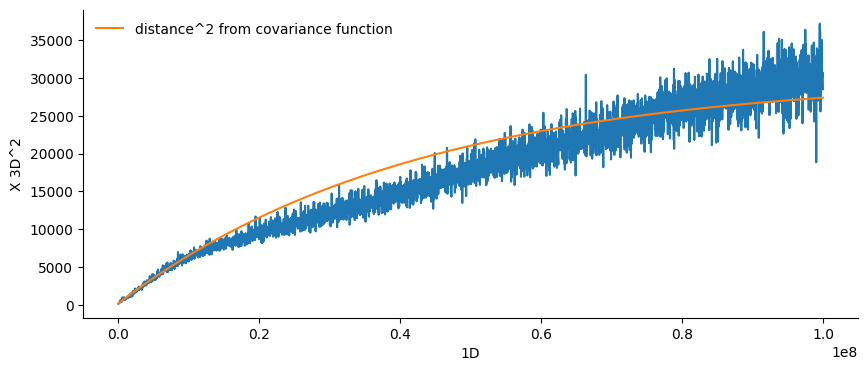

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(pwise_df, x="1D", y="X 3D^2", errorbar=None, ax=ax)
x_s, x_r = 1.5e4, 4.2e7
# x_s, x_r = 2.5e4, 4.5e7
x = np.unique(pwise_df["1D"])
y = 2*x_s - 2*covar_func(x, s=x_s, r=x_r) + 2*y_inteceps[0]
sns.lineplot(x=x, y=y, ax=ax, label="distance^2 from covariance function")

<Axes: xlabel='1D', ylabel='Y 3D^2'>

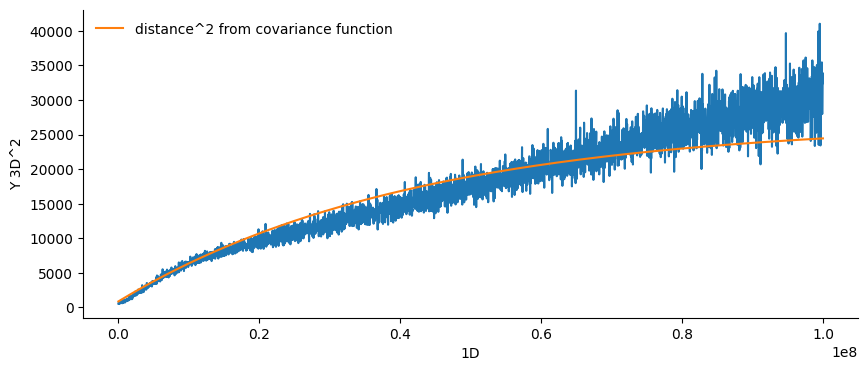

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(pwise_df, x="1D", y="Y 3D^2", errorbar=None, ax=ax)
y_s, y_r = 1.3e4, 4.2e7
# y_s, y_r = 2.5e4, 4.5e7
x = np.unique(pwise_df["1D"])
y = 2*y_s - 2*covar_func(x, s=y_s, r=y_r) + 2*y_inteceps[1]
sns.lineplot(x=x, y=y, ax=ax, label="distance^2 from covariance function")

<Axes: xlabel='1D', ylabel='Z 3D^2'>

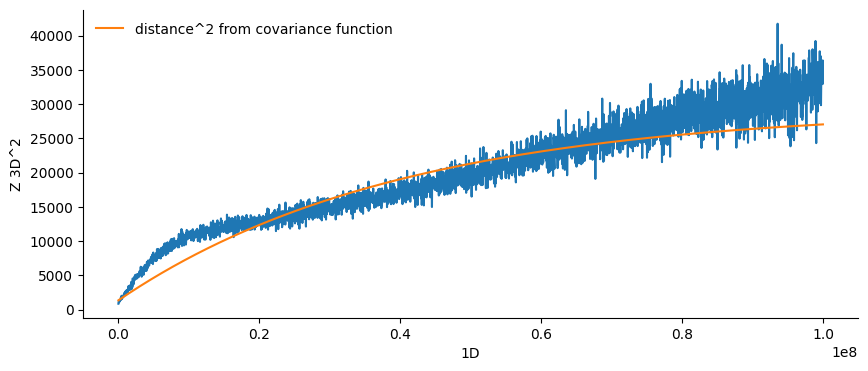

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(pwise_df, x="1D", y="Z 3D^2", errorbar=None, ax=ax)
z_s, z_r = 1.4e4, 4e7
# z_s, z_r = 5e4, 4e7
x = np.unique(pwise_df["1D"])
y = 2*z_s - 2*covar_func(x, s=z_s, r=z_r) + 2*y_inteceps[2]
sns.lineplot(x=x, y=y, ax=ax, label="distance^2 from covariance function")

In [10]:
tau_2 = np.array(y_inteceps)
s_all = np.array([x_s, y_s, z_s])
r_all = np.array([x_r, y_r, z_r])

## 3 Kriging

In [ ]:
trace_df_ls = []
for plot_trace_id in filtered_df.Trace_ID.unique():
    trace_df_complete = filtered_df[filtered_df["Trace_ID"]==plot_trace_id].copy()
    trace_df = trace_df_complete[["Chrom_Start", "X", "Y", "Z"]]

    pos = trace_df.dropna()["Chrom_Start"].values[:,None]
    S_all = [
        covar_func(pos - pos.T, s=s, r=r) 
        + np.identity(len(pos)) * t
        for s, r, t in zip(s_all, r_all, tau_2)
    ]
    Sinv_all = np.linalg.inv(S_all)

    coors = trace_df.dropna()[["X", "Y", "Z"]].values
    muhat = np.diag(np.sum(Sinv_all, axis=1)@coors)/np.sum(Sinv_all, axis=(1,2))

    pred_pos = trace_df["Chrom_Start"].values
    pos_mat = np.vstack([np.tile(pos, len(pred_pos)), pred_pos])
    K_all = [covar_func(pred_pos - pos, s=s, r=r) for s, r in zip(s_all, r_all)]
    krige_pred = np.array([K_all[i].T@Sinv_all[i]@(coors[:,i] - muhat[i]) + muhat[i] for i in range(3)])

    trace_df_complete[["X", "Y", "Z"]] = krige_pred.T
    trace_df_ls.append(trace_df_complete)
predict_df_all = pd.concat(trace_df_ls)

In [13]:
def plot_single_trace(trace_df, predict_df):
    fig = plt.figure(figsize=(16, 7), layout="constrained")
    fig1, fig2 = fig.subfigures(1, 2, width_ratios=[10, 4])
    axes = fig1.subplots(3, 1, sharex=True)
    for i, axis in enumerate(["X", "Y", "Z"]):
        pred_plt = predict_df.set_index("Chrom_Start").rename({axis:"Predicted"}, axis=1)
        df_plt = trace_df.set_index("Chrom_Start").rename({axis:"Observed"}, axis=1)

        plot_df = pd.concat([pred_plt["Predicted"], df_plt[["Observed"]]], axis=1).reset_index()
        plot_df = plot_df.melt("Chrom_Start", ["Predicted", "Observed"], "Type", "val")

        sns.scatterplot(plot_df, x="Chrom_Start", y="val", hue="Type", ax=axes[i])
        axes[i].set(xlabel="1D Genomic Location (bp)", ylabel=f"{axis} axis")

    ax1 = fig2.add_subplot(2, 1, 1, projection="3d")
    ax1.plot(predict_df.X, predict_df.Y, predict_df.Z, ".-", color="b")
    ax1.plot(trace_df.X, trace_df.Y, trace_df.Z, ".", color=pal[1])
    ax1.set(xlabel="x (nm)", ylabel="y (nm)", zlabel="z (nm)")

    pd_pred = pdist(predict_df.iloc[:,1:].values)
    mat_pred = np.identity(len(predict_df))
    triu_idx = np.triu_indices_from(mat_pred, k=1)
    mat_pred[triu_idx] = pd_pred
    mat_pred.T[triu_idx] = pd_pred

    ax2 = fig2.add_subplot(2, 1, 2)
    sns.heatmap(
        mat_pred, cmap=cmap, square=True,
        cbar=False, xticklabels=False, ax=ax2
    )
    ax2.set(title="Pairwise Distance (nm)")

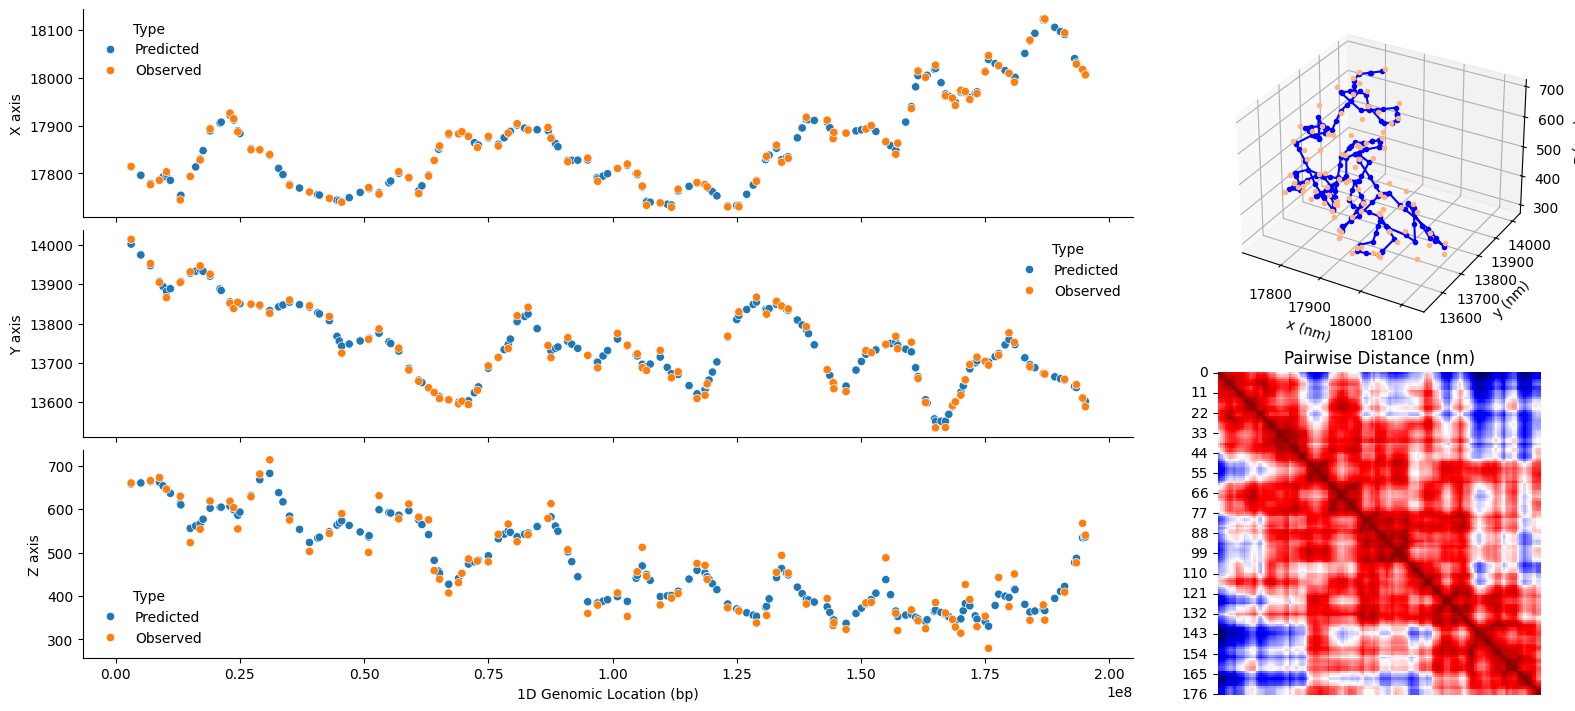

In [14]:
plot_id = predict_df_all.Trace_ID.unique()[0]
trace_df = filtered_df[filtered_df["Trace_ID"]==plot_id][["Chrom_Start", "X", "Y", "Z"]]
predict_df = predict_df_all[predict_df_all["Trace_ID"]==plot_id][["Chrom_Start", "X", "Y", "Z"]]

plot_single_trace(trace_df, predict_df)

In [15]:
reg_id = "chr3"

df = filtered_df[filtered_df["Chrom"]==reg_id]
pdists_raw = np.stack(df.groupby("Trace_ID", sort=False)[["X", "Y", "Z"]].apply(pdist).values)

df = predict_df_all[predict_df_all["Chrom"]==reg_id]
pdists_pred = np.stack(df.groupby("Trace_ID", sort=False)[["X", "Y", "Z"]].apply(pdist).values)

<Axes: >

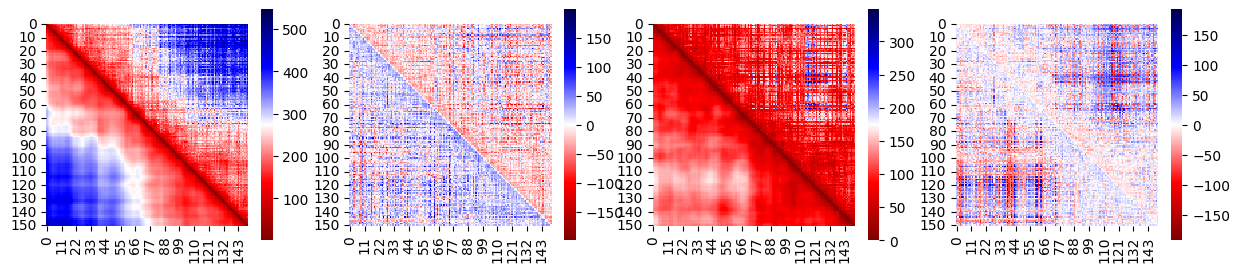

In [17]:
k = len(pd.unique(df["Chrom_Start"]))
mat = np.identity(k)

fig, axes = plt.subplots(1, 4, figsize=(15, 3))

mat[np.triu_indices_from(mat, 1)] = np.nanmean(pdists_raw, axis=0)
mat.T[np.triu_indices_from(mat, 1)] = np.nanmean(pdists_pred, axis=0)
sns.heatmap(mat, cmap=cmap, square=True, ax=axes[0])
mat = mat.T - mat
sns.heatmap(mat, cmap=cmap, square=True, ax=axes[1])

mat[np.triu_indices_from(mat, 1)] = np.nanstd(pdists_raw, axis=0)
mat.T[np.triu_indices_from(mat, 1)] = np.nanstd(pdists_pred, axis=0)
sns.heatmap(mat, cmap=cmap, square=True, ax=axes[2])
mat = mat.T - mat
sns.heatmap(mat, cmap=cmap, square=True, ax=axes[3])

## 4 HeteroPCA

<Axes: >

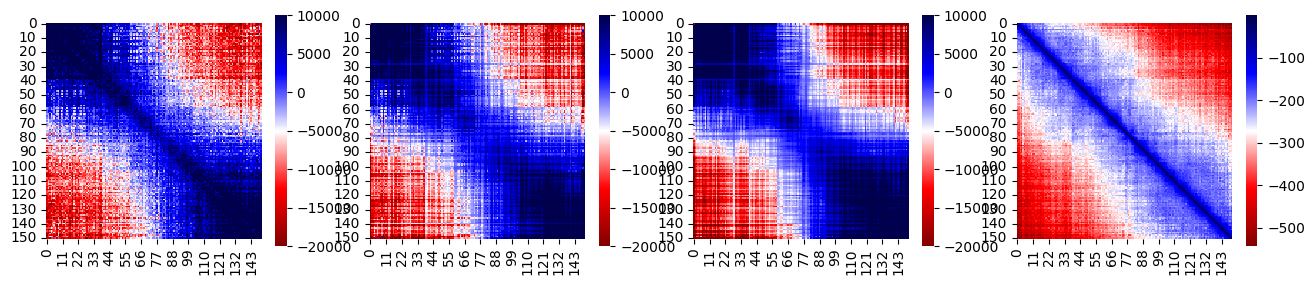

In [5]:
reg_id = "chr3"

df = filtered_df[filtered_df["Chrom"]==reg_id]

pdists_raw = np.stack(df.groupby("Trace_ID", sort=False)[["X", "Y", "Z"]].apply(pdist).values)
k = len(pd.unique(df["Chrom_Start"]))
mat = np.identity(k)
mat[np.triu_indices_from(mat, 1)] = np.nanmean(pdists_raw, axis=0)
mat.T[np.triu_indices_from(mat, 1)] = np.nanmean(pdists_raw, axis=0)

df = df.pivot(index="Trace_ID", values=["X", "Y", "Z"], columns="Chrom_Start")
arr = np.array([df[axis].values for axis in ["X", "Y", "Z"]])

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vmin, vmax = -2e4, 1e4
sns.heatmap(LohCov(df["X"].values), cmap=cmap, square=True, vmin=vmin, vmax=vmax, ax=axes[0])
sns.heatmap(HeteroPCA(df["X"].values), cmap=cmap, square=True, vmin=vmin, vmax=vmax, ax=axes[1])
sns.heatmap(HeteroPCAaxes(arr)[0], cmap=cmap, square=True, vmin=vmin, vmax=vmax, ax=axes[2])
A = matrixA(k)
sns.heatmap(-mat, cmap=cmap, square=True, ax=axes[3])

In [6]:
results = [[], [], []]
for c, df in filtered_df.groupby("Chrom", sort=False):
    df = df.pivot(index="Trace_ID", values=["X", "Y", "Z"], columns="Chrom_Start")
    arr = np.array([df[axis].values for axis in ["X", "Y", "Z"]])
    for i, item in enumerate(HeteroPCAaxes(arr)):
        results[i].append(item)
ests, sizes = np.hstack(results[1]), np.hstack(results[2])
tau_sq_hat = np.sum(sizes*ests, axis=1)/np.sum(sizes, axis=1)
np.sqrt(tau_sq_hat)

array([52.29188238, 49.79708572, 66.88303537])

In [48]:
results = [[], [], []]
for c, df in filtered_df.groupby("Chrom", sort=False):
    df = df.pivot(index="Trace_ID", values=["X", "Y", "Z"], columns="Chrom_Start")
    arr = np.array([df[axis].values for axis in ["X", "Y", "Z"]])
    for i, item in enumerate(HeteroPCAaxes(arr)):
        results[i].append(item)
ests, sizes = np.hstack(results[1]), np.hstack(results[2])
tau_sq_hat = np.sum(sizes*ests, axis=1)/np.sum(sizes, axis=1)
np.sqrt(tau_sq_hat)

array([84.85817058, 83.34397337, 94.55056093])

In [50]:
results = [[], [], []]
for c, df in filtered_df.groupby("Chrom", sort=False):
    df = df.pivot(index="Trace_ID", values=["X", "Y", "Z"], columns="Chrom_Start")
    arr = np.array([df[axis].values for axis in ["X", "Y", "Z"]])
    for i, item in enumerate(HeteroPCAaxes(arr)):
        results[i].append(item)
ests, sizes = np.hstack(results[1]), np.hstack(results[2])
tau_sq_hat = np.sum(sizes*ests, axis=1)/np.sum(sizes, axis=1)
np.sqrt(tau_sq_hat)

KeyboardInterrupt: 

## 5 More Simulations

In [4]:
def samples_axes(
        N, R, 
        s, r, covar_func, 
        tau_x, tau_y, tau_z, 
        obs_p, 
        random_shift
):
    if random_shift:
        shifts = stats.uniform.rvs(scale=1e3, size=(3, N))
    else:
        shifts = np.zeros((3, N)) # shifts of each trace in each axis

    tau_sq = np.square(np.array([tau_x, tau_y, tau_z]))
    pos = np.arange(R)[:,None]
    K = covar_func(pos - pos.T, s=s, r=r)

    sample_ls = []
    for i, t in enumerate(tau_sq):
        merr_cov = np.identity(R)*t
        merr = stats.multivariate_normal.rvs(cov=merr_cov, size=N)

        # measurement error + shift for each trace
        sample = stats.multivariate_normal.rvs(cov=K, size=N)
        sample = sample + merr + shifts[i][:,None]

        # missing at random
        mask_ber = stats.bernoulli.rvs(obs_p, size=R*N)
        mask_ber = mask_ber.reshape(sample.shape)
        sample = np.where(mask_ber==1, sample, np.nan)

        sample_ls.append(sample)
    samples = np.stack(sample_ls)
    return samples, K

In [5]:
N, R = 1000, 50 # sample size and dimension
s, r = 50, 50 # parameters for covariance function
tau_x, tau_y, tau_z = 5, 5, 5 # measurement error
obs_p = 0.5 # observed probability
random_shift = True
samples, K = samples_axes(N, R, s, r, covar_func, tau_x, tau_y, tau_z, obs_p, random_shift)

In [6]:
HetAxs_K_hat = HeteroPCAaxes(samples)[0]

In [7]:
samples_long = np.vstack(samples)
LohCov_K_hat = LohCov(samples_long, shift=True)
Hetero_K_hat = HeteroPCA(samples_long, shift=False)

In [8]:
samples_long_mu = []
tau_sq = np.square(np.array([tau_x, tau_y, tau_z]))
for a, t in zip(samples, tau_sq):
    for z in a:
        sub_K = K[~np.isnan(z),:][:,~np.isnan(z)]
        sub_S = sub_K + np.identity(sub_K.shape[0])*t
        Sinv = np.linalg.inv(sub_S)
        mu_hat = z[~np.isnan(z)]@np.sum(Sinv, axis=0)/np.sum(Sinv)
        samples_long_mu.append(z - mu_hat)
samples_long_mu = np.stack(samples_long_mu)
samples_long_mu = samples_long_mu - np.nanmean(samples_long_mu, axis=0)
samples_long_mu.shape

(3000, 50)

In [15]:
np.random.normal(loc=0, scale=200, size=(N, R))

array([[-167.76425476,  -28.36910719,  165.82581264, ..., -199.23126145,
          -1.4468508 , -156.20730198],
       [  62.95632305,  -95.86494443, -287.09273356, ...,  214.53980666,
        -237.22873606,  -99.40797794],
       [ -93.55849771,  -94.72930625,  198.55274022, ...,  -69.26094021,
          96.51621993,   55.30681096],
       ...,
       [ -85.45918849,  226.68544608, -146.35054815, ...,   78.27334493,
         -65.80187853,  257.04377373],
       [ -24.87067355,  320.5234523 ,  398.93285615, ..., -195.60196025,
          26.69043613, -255.77682895],
       [  43.06773181,  261.23805874,  239.42969618, ...,   32.52504427,
         179.94124251,  331.6224529 ]])

In [9]:
Hetero_K_hat_mu = HeteroPCA(samples_long_mu, shift=True)

In [10]:
A = matrixA(R)
# A = (A*3**2).astype("int")
# A[-3] += A[-2] + A[-1]
# A[0] += A[1] + A[2]

In [11]:
N = scipy.linalg.null_space(A)

In [13]:
S1 = scipy.linalg.lstsq(A, LohCov_K_hat.flat)

<Axes: >

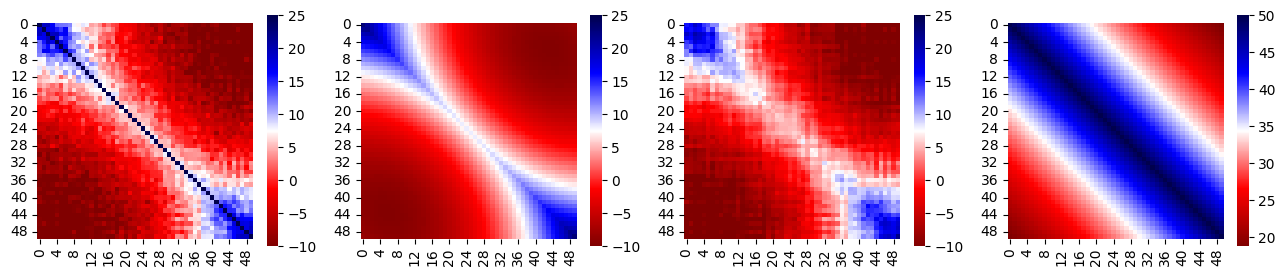

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vmin, vmax = -10, 25
sns.heatmap(LohCov_K_hat, cmap=cmap, square=True, vmin=vmin, vmax=vmax, ax=axes[0])
sns.heatmap((A@K.flat).reshape(K.shape), cmap=cmap, square=True, vmin=vmin, vmax=vmax, ax=axes[1])
sns.heatmap(Hetero_K_hat_mu, cmap=cmap, square=True, vmin=vmin, vmax=vmax, ax=axes[2])
vmin, vmax = None, None
sns.heatmap(K, cmap=cmap, square=True, vmin=vmin, vmax=vmax, ax=axes[3])

In [56]:
np.diag(LohCov_K_hat)

array([46.4673427 , 44.62516414, 46.05023342, 43.1005382 , 41.51597962,
       41.54662743, 42.47261665, 39.20120432, 35.92479307, 37.75156035,
       37.68922191, 38.16447831, 34.31249017, 34.28936582, 32.71958243,
       33.97926288, 32.18935962, 34.51383174, 33.31551834, 31.53307009,
       33.66162147, 32.04302931, 31.38156146, 32.45814652, 31.85310921,
       33.34595727, 31.00069215, 32.1446777 , 30.80023758, 31.56691818,
       33.46555527, 30.94350213, 31.32689746, 32.06431111, 32.14326356,
       34.09480852, 36.394053  , 34.65094197, 37.52111726, 36.71477503,
       37.32223412, 36.97984995, 40.00966678, 41.27564822, 41.72205257,
       46.11818884, 43.0534605 , 43.18048622, 45.21481398, 46.49301154])

In [87]:
psq = np.square([t[:,None] - t[None,:] for t in samples_long])
msq = np.square([t[:,None] + t[None,:] for t in samples_long])
d, m = np.nanmean(psq, axis=0), np.nanmean(msq, axis=0)

In [14]:
K

array([[50.        , 49.00993367, 48.03947196, ..., 19.53139177,
        19.1446443 , 18.76555494],
       [49.00993367, 50.        , 49.00993367, ..., 19.92595205,
        19.53139177, 19.1446443 ],
       [48.03947196, 49.00993367, 50.        , ..., 20.32848299,
        19.92595205, 19.53139177],
       ...,
       [19.53139177, 19.92595205, 20.32848299, ..., 50.        ,
        49.00993367, 48.03947196],
       [19.1446443 , 19.53139177, 19.92595205, ..., 49.00993367,
        50.        , 49.00993367],
       [18.76555494, 19.1446443 , 19.53139177, ..., 48.03947196,
        49.00993367, 50.        ]])

<Axes: >

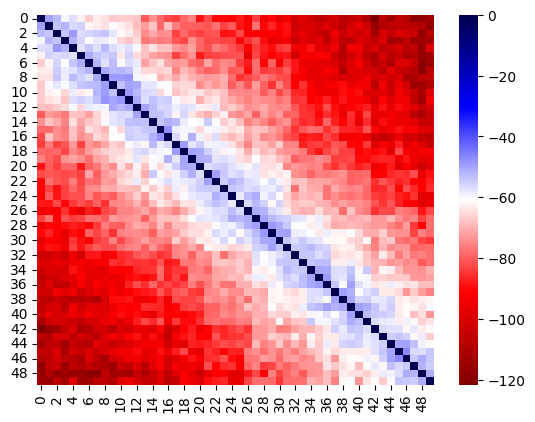

In [18]:
sns.heatmap(-d, cmap=cmap)

In [20]:
s1 = np.identity(R)
B = np.tile(s1, (R, 1)) + np.repeat(s1, R, axis=0)
np.linalg.matrix_rank(A@B)

50

In [29]:
c = LohCov_K_hat.flat
sol, resid, rank, svals = np.linalg.lstsq(A@B/2, c + A@d.flat/2, rcond=None)

<Axes: >

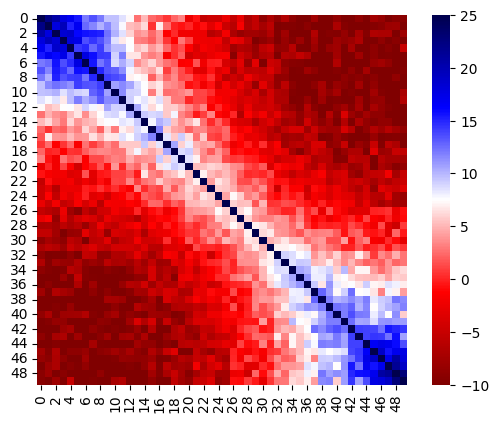

In [31]:
vmin, vmax = -10, 25
sns.heatmap((A@(B@np.diag(K) - d.flat)).reshape((R, R))/2, cmap=cmap, square=True, vmin=vmin, vmax=vmax)

<Axes: >

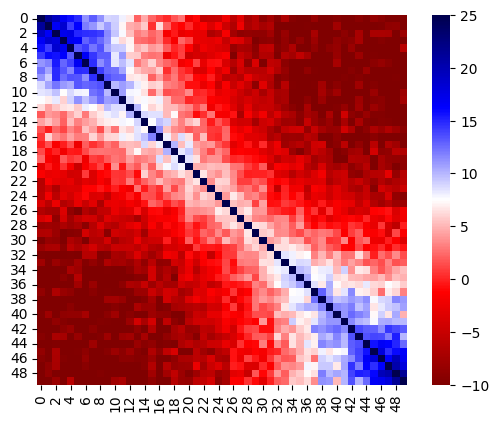

In [53]:
# ss = np.ones(R)*10000
ss = np.random.uniform(0, 1000, R)
sns.heatmap((A@B@sol - A@d.flat).reshape((R,R))/2, cmap=cmap, square=True, vmin=vmin, vmax=vmax)

In [62]:
s1 = np.diag(ss) @ np.ones((R, R))
np.linalg.matrix_rank(s1 + s1.T)
sss = s1 + s1.T

In [64]:
eigv = np.linalg.eig(-d).eigenvectors

array([29543.12826192, 66645.18991086, 47374.1161565 , 35028.28916036,
       26912.24369919, 50609.99555055, 67555.17963587, 25659.25026688,
       70349.86650955, 68249.59036999, 34498.38402946, 78118.26926713,
       46045.41938682, 26049.05252989, 29820.42146412, 53291.89469371,
       69287.27815212, 47169.04866703, 73947.16847529, 29347.32801597,
       65189.83198763, 52292.56623003, 79716.67272427, 40532.24516656,
       77303.45332434, 70438.25879825, 38214.77188907, 50026.0070607 ,
       32033.47693953, 60349.44481617, 54865.31999855, 27421.68668468,
       49888.05230374, 66422.44834406, 50291.34467889, 37738.91681441,
       32019.60841055, 26676.4588289 , 73326.96517439, 50930.81905245,
       30520.35143898, 57096.10735952, 67250.81272608, 65075.41342661,
       25719.94668686, 58220.76306338, 63730.47351988, 50888.92595099,
       45940.89679261, 50927.32127599])

In [43]:
(np.ones((9,9)) @ np.diag(np.arange(1, 10))).T

array([[1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [6., 6., 6., 6., 6., 6., 6., 6., 6.],
       [7., 7., 7., 7., 7., 7., 7., 7., 7.],
       [8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [9., 9., 9., 9., 9., 9., 9., 9., 9.]])

<Axes: >

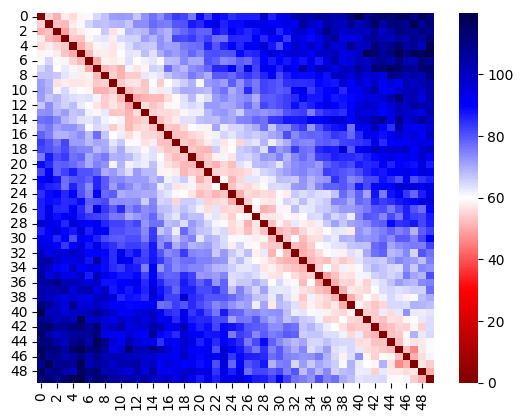

In [365]:
sns.heatmap(np.nanmean(psq, axis=0), cmap=cmap)

## 6 Estimate $\Sigma$

In [8]:
N, R = 1000, 50 # sample size and dimension
s, r = 50, 50 # parameters for covariance function
tau_x, tau_y, tau_z = 2, 5, 6 # measurement error
obs_p = 0.5 # observed probability
random_shift = False
samples, K = samples_axes(N, R, s, r, covar_func, tau_x, tau_y, tau_z, obs_p, random_shift)

6.714026488351108

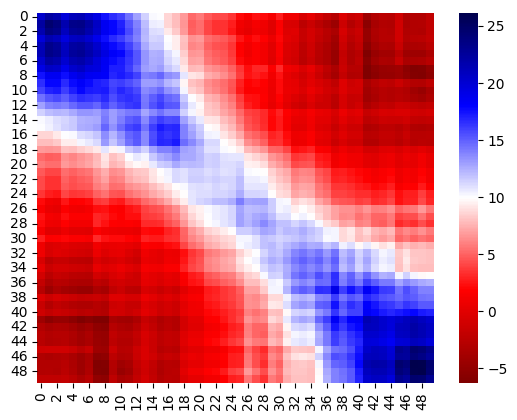

In [12]:
Ws = samples - np.nanmean(samples, axis=-1)[:,:,None]
W = Ws[0]
C1 = LohCov(W, shift=False)
C2 = HeteroPCA(W, shift=False, r=5, t=100)
ns = np.sum(~np.isnan(W), axis=0)
tau_sq_hat = np.sum(np.diag(C1 - C2)*ns)/np.sum(ns)
C_hat = C2 + tau_sq_hat
sns.heatmap(C_hat, cmap=cmap, )
tau_sq_hat

In [9]:
W = samples[2]
C1 = LohCov(W, shift=False)
C2 = HeteroPCA(W, shift=False, r=5, t=100)
np.sum(np.diag(C1 - C2)*ns)/np.sum(ns)

35.591473216822216

In [10]:
df = filtered_df[filtered_df["Chrom"]=="chr3"]
df = df.pivot(index="Trace_ID", values=["X", "Y", "Z"], columns="Chrom_Start")
arr = np.array([df[axis].values for axis in ["X", "Y", "Z"]])

Ws = arr - np.nanmean(arr, axis=-1)[:,:,None]
C1s, C2s, tau_sqs = [], [], []
for W in Ws:
    C1s.append(LohCov(W, shift=False))
    C2s.append(HeteroPCA(W, shift=False, r=20, t=100))
    ns = np.sum(~np.isnan(W), axis=0)
    tau_sq_hat = np.sum(np.diag(C1s[-1] - C2s[-1])*ns)/np.sum(ns)
    tau_sqs.append(tau_sq_hat)
    C_hat = C2 + tau_sq_hat
np.sqrt(tau_sqs)

/var/folders/r1/8ss2m8yd3616s_v12l580jcw0000gn/T/ipykernel_11358/3952806852.py:14: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(tau_sqs)


array([        nan, 52.95481612, 19.71621607])

<Axes: >

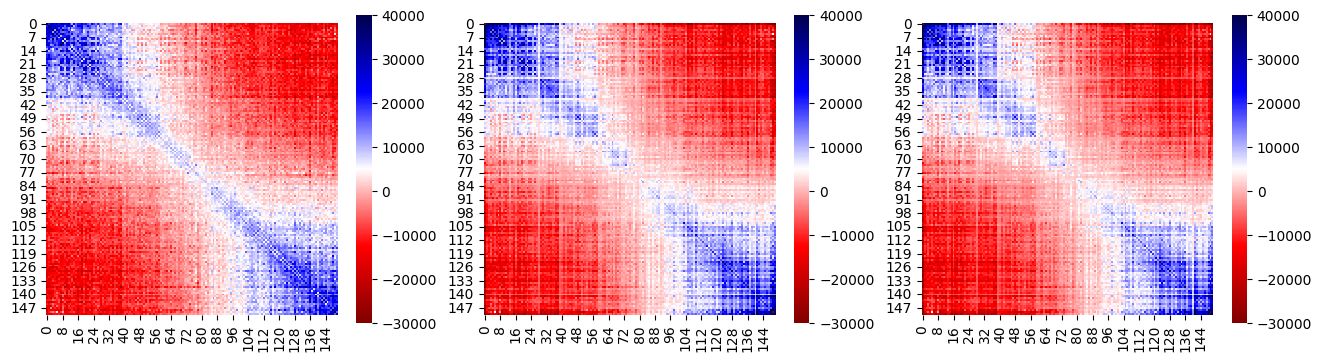

In [11]:
i = 0
C1, C2, tau_sq_hat = C1s[i], C2s[i], tau_sqs[i]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
vmin, vmax = -3e4, 4e4
sns.heatmap(C1, cmap=cmap, square=True, vmin=vmin, vmax=vmax, ax=axes[0])
sns.heatmap(C2, cmap=cmap, square=True, vmin=vmin, vmax=vmax, ax=axes[1])
sns.heatmap(C2 + tau_sq_hat, cmap=cmap, square=True, vmin=vmin, vmax=vmax, ax=axes[2])

<Axes: >

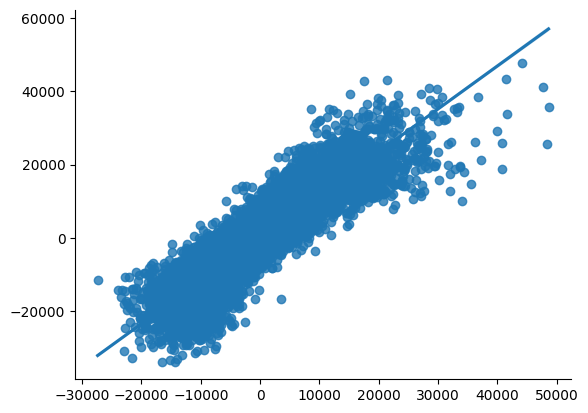

In [24]:
x = C1s[0][np.triu_indices_from(C1s[0])]
y = C1s[2][np.triu_indices_from(C1s[2])]
sns.regplot(x=x, y=y)

In [12]:
cov_means = np.array([
    np.mean(c[np.triu_indices_from(c, 1)])
    for c in C1s
])[:,None]
mean_diff = cov_means - cov_means.T


In [25]:
X = np.vstack([np.ones_like(x), x]).T
np.linalg.inv(X.T@X)@X.T@y

array([-1.91024189,  1.17399554])